In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
import numpy as np
import xlsxwriter
from openpyxl import load_workbook

In [2]:
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (25, 17),
         'axes.labelsize': 'large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

In [3]:
TEAMS= ["ATL", "BOS", "BRK", "CHI", "CHO", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", "MIN", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "TOR", "UTA", "WAS"]
WESTERN_CONF_TEAMS = ["DAL", "DEN", "GSW", "HOU", "LAC", "LAL", "MEM", "MIN", "NOP", "OKC", "PHO", "POR", "SAC", "SAS", "UTA"]
EASTERN_CONF_TEAMS = ["ATL", "BOS", "BRK", "CHI", "CHO", "CLE", "DET", "IND", "MIA", "MIL", "NYK", "ORL", "PHI", "TOR", "WAS"]
ATLANTIC_DIV_TEAMS = ["BOS", "BRK", "NYK", "PHI", "TOR"]
CENTRAL_DIV_TEAMS = ["CHI", "CLE", "DET", "IND", "MIL"]
SOUTHEAST_DIV_TEAMS = ["ATL", "CHO", "MIA", "ORL", "WAS"]
NORTHWEST_DIV_TEAMS = ["DEN", "MIN", "OKC", "POR", "UTA"]
SOUTHWEST_DIV_TEAM = ["GSW", "LAC", "LAL", "PHO", "SAC"]
PACIFIC_DIV_TEAMS = ["DAL", "HOU", "MEM", "NOP", "SAS"]
SEASONS = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
POSITIONS = ["PG", "SG", "SF", "PF", "C"]

In [4]:
def mean(data):
    return sum(data) / len(data)

In [5]:
def variance(data):
    n = len(data)
    avg = mean(data)
    
    deviations = [(x - avg) ** 2 for x in data]
    
    variance = sum(deviations) / n
    return variance

In [6]:
def std(data):
    var = variance(data)
    std = var ** 0.5
    return std

In [7]:
def growth_rate(data):
    straight_line_growth = []
    
    for i in range(1, len(data)):
        growth = (data[i] - data[i-1]) / data[i-1]
        straight_line_growth.append(growth)
        
    growth_rt = sum(straight_line_growth) / len(straight_line_growth)
    
    return "{:.2f}%".format(growth_rt*100)

In [8]:
def spearman_rank_corr(rank1, rank2):
    d_square = []
    
    if len(rank1) != len(rank2):
        return
    
    n = len(rank1)
    
    for i in range(n):
        d = rank1[i] - rank2[i]
        d_square.append(d ** 2)
    
    return 1 - ((6 * sum(d_square)) / (n * (n ** 2 - 1)))

In [9]:
def calculate_rank_corr_by_player_stat(df, eastern_standings, western_standings, stat, measure="mean"): #measure might be mean, sd or max
    if measure == "mean":
        grouped_df = pd.DataFrame(df.groupby(by=['Tm']).mean())
    elif measure == "sd":
        grouped_df = pd.DataFrame(df.groupby(by=['Tm']).std())
    elif measure == "max":
        grouped_df = pd.DataFrame(df.groupby(by=['Tm']).max())
    grouped_df.sort_values(by=[stat, 'Tm'], ascending=[False, True], inplace=True)
    
    teams = list(grouped_df.index)
    if "TOT" in teams:
        teams.remove("TOT")
    rank = range(1, 31)
    zip_iterator = zip(teams, rank)

    teams_ordered_by_stat = dict(zip_iterator)
    
    standings = merge_standings(eastern_standings, western_standings)
    
    print(teams_ordered_by_stat)
    
    rank1 = []
    rank2 = []
    for team in TEAMS:
        if team in standings:
            rank1.append(teams_ordered_by_stat[team])
            rank2.append(standings[team])

    return spearman_rank_corr(rank1, rank2)

In [10]:
def calculate_rank_corr_by_team_stat(df, eastern_standings, western_standings, stat):
    
    corr_df = df.sort_values(by=[stat, 'Team'], ascending=[False, True])
    
    corr_df.set_index('Team', inplace=True)
    
    teams = list(corr_df.index)
    rank = range(1, 31)
    zip_iterator = zip(teams, rank)

    teams_ordered_by_stat = dict(zip_iterator)
    
    standings = merge_standings(eastern_standings, western_standings)
    
    
    rank1 = []
    rank2 = []
    for team in TEAMS:
        if team in standings:
            rank1.append(teams_ordered_by_stat[team])
            rank2.append(standings[team])

    return spearman_rank_corr(rank1, rank2)

In [11]:
def rank_player_corrs_to_excel(dfs, eastern_standings_dfs, western_standings_dfs, stat, measure="mean"):
    corrs = [stat, measure]
    
    n = len(dfs)
    
    for i in range(n):
        corrs.append(calculate_rank_corr_by_player_stat(dfs[i], eastern_standings_dfs[i], western_standings_dfs[i], stat, measure))
        
    wb = load_workbook("Rank_Correlation_Player_Stats.xlsx")
    ws = wb.worksheets[0]
    
    ws.append(corrs)
    wb.save("Rank_Correlation_Player_Stats.xlsx")

In [12]:
def rank_team_corrs_to_excel(dfs, eastern_standings_dfs, western_standings_dfs, stat):
    corrs = [stat]
    
    n = len(dfs)
    
    for i in range(n):
        corrs.append(calculate_rank_corr_by_team_stat(dfs[i], eastern_standings_dfs[i], western_standings_dfs[i], stat))
        
    wb = load_workbook("Results/Correlation/Rank_Correlation_Team_Stats.xlsx")
    ws = wb.worksheets[0]
    
    ws.append(corrs)
    wb.save("Results/Correlation/Rank_Correlation_Team_Stats.xlsx")

In [13]:
def merge_standings(eastern_standings, western_standings):
    standings = pd.concat([western_standings, eastern_standings])
    standings.sort_values(by=["Made_Playoffs", "W", "Rank", "Team"], ascending=[False, False, True, True], inplace=True)
    standings.reset_index(inplace=True)
    standings.drop('index', axis=1, inplace=True)
    standings.index += 1
    teams_ranked = dict(standings["Team"])
    inv_teams_ranked = {v: k for k, v in teams_ranked.items()}
    return inv_teams_ranked

In [14]:
def format_season(season):
        #Formats years in season to use in File Name
        #Ex: 2021 turns into 2020-21
        first_year = season-1
        second_year = str(season)[2:]
        
        return first_year, second_year

In [15]:
def get_csvs_by_season(season):
    first_year, second_year = format_season(season)

    player_df = pd.read_csv("DataCollection/Player_Stats/player_stats_{0}-{1}.csv".format(first_year, second_year))
    team_df = pd.read_csv("DataCollection/Team_Stats/team_stats_{0}-{1}.csv".format(first_year, second_year))
    adv_team_df = pd.read_csv("DataCollection/Advanced_Team_Stats/adv_team_stats_{0}-{1}.csv".format(first_year, second_year))
    opponent_df = pd.read_csv("DataCollection/Opponent_Stats/opponent_stats_{0}-{1}.csv".format(first_year, second_year))
    eastern_standings_df = pd.read_csv("DataCollection/Standings/standings_eastern_conference_{0}-{1}.csv".format(first_year, second_year))
    western_standings_df = pd.read_csv("DataCollection/Standings/standings_western_conference_{0}-{1}.csv".format(first_year, second_year))

    return player_df, team_df, adv_team_df, opponent_df, eastern_standings_df, western_standings_df

In [16]:
player_dfs, team_dfs, adv_team_dfs, opponent_dfs, eastern_standings_dfs, western_standings_dfs = [], [], [], [], [], []

for season in SEASONS:
    player_df, team_df, adv_team_df, opponent_df, eastern_standings_df, western_standings_df = get_csvs_by_season(season)
    player_dfs.append(player_df)
    team_dfs.append(team_df)
    adv_team_dfs.append(adv_team_df)
    opponent_dfs.append(opponent_df)
    eastern_standings_dfs.append(eastern_standings_df)
    western_standings_dfs.append(western_standings_df)

In [17]:
stats = ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS']

In [18]:
adv_stats = ['W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg',
       'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'Off_eFG%', 'Off_TOV%',
       'Off_ORB%', 'Off_FT/FGA', 'Def_eFG%', 'Def_TOV%', 'Def_DRB%',
       'Def_FT/FGA', 'Arena', 'Attend.', 'Attend./G']

In [19]:
for stat in stats:
    rank_team_corrs_to_excel(team_dfs, eastern_standings_dfs, western_standings_dfs, stat)

In [20]:
for stat in adv_stats:
    rank_team_corrs_to_excel(adv_team_dfs, eastern_standings_dfs, western_standings_dfs, stat)

In [21]:
df = pd.read_excel("Results/Correlation/Rank_Correlation_Team_Stats.xlsx")
df.set_index("Stat", inplace=True)
df

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Stat,,,,,,,,,,,,,,,,,,,
G,-0.180788,0.104926,-0.008231,0.051835,-0.038932,-0.013126,0.256507,0.123026,0.123026,0.117686,0.097664,0.020245,0.227586,0.163960,0.034483,-0.165740,-0.143048,0.642714,-0.026029
MP,0.046798,-0.286207,-0.076307,-0.218687,-0.352614,-0.451835,-0.114127,0.024694,-0.197775,0.484316,0.243604,-0.088320,-0.034483,0.204449,-0.116796,0.111457,-0.130590,-0.200445,0.138154
FG,0.475369,0.274877,0.258287,0.289878,0.363293,0.271635,0.217353,0.204449,0.103893,0.397998,0.385984,0.438932,0.640934,0.470968,0.284538,0.519911,0.478087,0.418020,0.511457
FGA,0.091626,-0.131527,-0.066073,0.058954,0.140378,-0.161290,-0.405562,-0.349499,-0.478087,-0.067853,-0.400222,-0.270300,0.127920,0.005562,-0.261846,-0.179533,0.140378,-0.090100,-0.094994
FG%,0.590640,0.543350,0.408676,0.348165,0.381535,0.675195,0.732592,0.599110,0.645829,0.632481,0.622247,0.702336,0.713904,0.503003,0.606229,0.647164,0.543493,0.626696,0.662291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Def_DRB%,0.142857,0.481281,0.172859,0.375751,0.474972,0.424694,0.494994,0.480756,0.460734,0.515907,0.296107,0.299666,0.022914,0.288988,-0.038932,0.225362,0.444271,0.325918,0.470078
Def_FT/FGA,-0.401478,-0.236946,-0.302336,-0.480756,-0.230256,-0.258287,-0.284538,-0.269410,-0.593771,-0.327253,-0.189766,-0.330367,-0.349055,-0.222247,-0.249833,-0.189321,-0.163515,-0.204004,-0.098109
Arena,-0.017734,-0.126601,-0.057175,-0.185317,0.018020,0.205784,0.034483,-0.215128,-0.280979,-0.310345,-0.368632,-0.272525,-0.113682,-0.345495,-0.033148,0.129255,0.019800,-0.025584,0.076752


ValueError: x and y must have same first dimension, but have shapes (19,) and (2, 19)

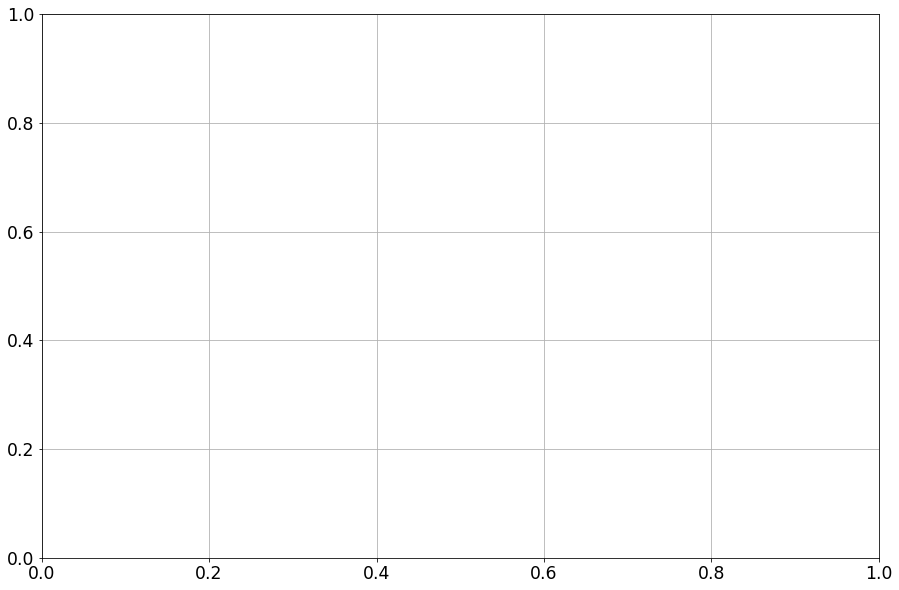

In [22]:
plt.figure(figsize=(15,10))

plt.grid()
plt.plot(SEASONS, df.loc["FG"], label="FG")
plt.plot(SEASONS, df.loc["FGA"], label="FGA")
plt.plot(SEASONS, df.loc["FG%"], label="FG%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between FGs per game and the final regular season standings")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.grid()
plt.plot(SEASONS, df.loc["3P"], label="3P")
plt.plot(SEASONS, df.loc["3PA"], label="3PA")
plt.plot(SEASONS, df.loc["3P%"], label="3P%")
plt.plot(SEASONS, df.loc["3PAr"], label="3PAr")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between 3Ps per game as a team and the final regular season standings")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["2P"], label="2P")
plt.plot(SEASONS, df.loc["2PA"], label="2PA")
plt.plot(SEASONS, df.loc["2P%"], label="2P%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between 2Ps per game as a team and the final regular season standings")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["FT"], label="FT")
plt.plot(SEASONS, df.loc["FTA"], label="FTA")
plt.plot(SEASONS, df.loc["FT%"], label="FT%")
plt.plot(SEASONS, df.loc["FTr"], label="FTr")

plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between FTs per game as a team and the final regular season standings")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["ORB"], label="ORB")
plt.plot(SEASONS, df.loc["DRB"], label="DRB")
plt.plot(SEASONS, df.loc["TRB"], label="TRB")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between Rebounds per game as a team and the final regular season standings")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["AST"], label="AST")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between assists per game as a team and the final regular season standings")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["STL"], label="STL")
plt.plot(SEASONS, df.loc["BLK"], label="BLK")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between steals and blocks per game as a team and the final regular season standings")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["TOV"], label="TOs")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between turnovers per game as a team and the final regular season standings")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["PF"], label="PFs")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between personal fouls per game as a team and the final regular season standings")
plt.legend()
plt.savefig("Correlation_PFs_Standings.png")
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["PTS"], label="PPG")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between PPG as a team and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["MOV"], label="PPG")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between margin of victory and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["SOS"], label="Strength of schedule")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation betweenstrength of schedule and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["SRS"], label="SRS")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between the simple rating system and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["ORtg"], label="ORtg")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between rating and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["ORtg"], label="ORtg")
plt.plot(SEASONS, df.loc["DRtg"], label="DRtg")
plt.plot(SEASONS, df.loc["NRtg"], label="NRtg")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between rating and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["TS%"], label="TS%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between true shooting percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Off_eFG%"], label="Offensive eFG%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between offensive effective fiel goal percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Off_TOV%"], label="Offensive TO%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between offensive turnover percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Off_ORB%"], label="Offensive rebound%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between offensive rebound percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.grid()
plt.plot(SEASONS, df.loc["Off_FT/FGA"], label="Offensive free throw per field goal attempt")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between free throw per field goal attempt and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Def_eFG%"], label="Defensive eFG%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between defensive effective fiel goal percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Def_TOV%"], label="Defensive TO%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between defensive turnover percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Def_DRB%"], label="Defensive rebound%")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between Defensive rebound percetnage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Def_FT/FGA"], label="Defensive free throw per field goal attempt")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between free throw per field goal attempt on the defense and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, df.loc["Attend./G"], label="Attendance per game")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation betwee fan attendance per game and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
player_stas

In [ ]:
player_df = pd.read_excel("DataCollection/Correlation/Rank_Correlation_Player_Stats.xlsx")
player_df.set_index(["Stat", "Measure"], inplace=True)
player_df

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["Age", "mean"], label="Age mean")
plt.plot(SEASONS, player_df.loc["Age", "max"], label="Max age")
plt.plot(SEASONS, player_df.loc["Age", "sd"], label="Age sd")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between age of the players and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["FG", "sd"], label="FG sd")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between made field goals standard deviation between the players and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["FTA", "max"], label="FTA max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between players with the most FTA and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["PTS", "mean"], label="PTS mean")
plt.plot(SEASONS, player_df.loc["PTS", "sd"], label="PTS sd")
plt.plot(SEASONS, player_df.loc["PTS", "max"], label="PTS max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between PTS and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["PER", "mean"], label="PER mean")
plt.plot(SEASONS, player_df.loc["PER", "sd"], label="PER sd")
plt.plot(SEASONS, player_df.loc["PER", "max"], label="PER max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between PER and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["TS%", "mean"], label="TS% mean")
plt.plot(SEASONS, player_df.loc["TS%", "sd"], label="TS% sd")
plt.plot(SEASONS, player_df.loc["TS%", "max"], label="TS% max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between true shooting % and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["OWS", "mean"], label="OWS mean")
plt.plot(SEASONS, player_df.loc["OWS", "sd"], label="OWS sd")
plt.plot(SEASONS, player_df.loc["OWS", "max"], label="OWS max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between offensive win share and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["DWS", "mean"], label="DWS mean")
plt.plot(SEASONS, player_df.loc["DWS", "sd"], label="DWS sd")
plt.plot(SEASONS, player_df.loc["DWS", "max"], label="DWS max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between deffensive win share and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["WS", "mean"], label="WS mean")
plt.plot(SEASONS, player_df.loc["WS", "sd"], label="WS sd")
plt.plot(SEASONS, player_df.loc["WS", "max"], label="WS max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between win share and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["USG%", "mean"], label="USG% mean")
plt.plot(SEASONS, player_df.loc["USG%", "sd"], label="USG% sd")
plt.plot(SEASONS, player_df.loc["USG%", "max"], label="USG% max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between usage and the final regular season standings")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(SEASONS, player_df.loc["Salary", "mean"], label="Salary mean")
plt.plot(SEASONS, player_df.loc["Salary", "sd"], label="Salary sd")
plt.plot(SEASONS, player_df.loc["Salary", "max"], label="Salary max")
plt.xticks(SEASONS)
plt.yticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1,0])
plt.ylabel("Correlation")

plt.title("Correlation between salary and the final regular season standings")
plt.legend()
plt.show()